# Machine Learning for Factor Investing

http://www.mlfactor.com/

Book and original R code by Guillaume Coqueret and Tony Guida

Python code by Vinicius Esposito

### **Chapter 0.** Importing stuff and setup


In [1]:
# Basic stuff
import pandas as pd
import numpy as np
import datetime
from calendar import monthrange

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
plt.rcParams['patch.facecolor'] = 'white'
import graphviz

# Reading Rdata - need to install in Collab
# !pip install pyreadr
import pyreadr

# Stats/modeling
from statsmodels.formula.api import ols
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow import keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### **Chapter 1.** Notations and data


In [2]:
Rdata = pyreadr.read_r('/content/drive/MyDrive/data/data_ml.RData')

data = Rdata['data_ml']
data['date'] = pd.to_datetime(data['date'], format = '%Y-%m-%d')

data.head()

,stock_id,date,Advt_12M_Usd,Advt_3M_Usd,Advt_6M_Usd,Asset_Turnover,Bb_Yld,Bv,Capex_Ps_Cf,Capex_Sales,Cash_Div_Cf,Cash_Per_Share,Cf_Sales,Debtequity,Div_Yld,Dps,Ebit_Bv,Ebit_Noa,Ebit_Oa,Ebit_Ta,Ebitda_Margin,Eps,Eps_Basic,Eps_Basic_Gr,Eps_Contin_Oper,Eps_Dil,Ev,Ev_Ebitda,Fa_Ci,Fcf,Fcf_Bv,Fcf_Ce,Fcf_Margin,Fcf_Noa,Fcf_Oa,Fcf_Ta,Fcf_Tbv,Fcf_Toa,Fcf_Yld,Free_Ps_Cf,...,Oa,Ocf,Ocf_Bv,Ocf_Ce,Ocf_Margin,Ocf_Noa,Ocf_Oa,Ocf_Ta,Ocf_Tbv,Ocf_Toa,Op_Margin,Op_Prt_Margin,Oper_Ps_Net_Cf,Pb,Pe,Ptx_Mgn,Recurring_Earning_Total_Assets,Return_On_Capital,Rev,Roa,Roc,Roce,Roe,Sales_Ps,Share_Turn_12M,Share_Turn_3M,Share_Turn_6M,Ta,Tev_Less_Mktcap,Tot_Debt_Rev,Total_Capital,Total_Debt,Total_Debt_Capital,Total_Liabilities_Total_Assets,Vol1Y_Usd,Vol3Y_Usd,R1M_Usd,R3M_Usd,R6M_Usd,R12M_Usd
0,13,2006-12-31,0.25,0.33,0.27,0.22,0.33,0.01,0.13,0.84,0.13,0.16,0.01,0.5,0.26,0.30,1.00,0.01,0.01,0.01,0.01,0.03,0.03,0.58,0.03,0.03,0.17,0.02,0.5,0.10,1.00,0.01,0.02,0.01,0.01,0.01,0.82,0.01,0.06,0.16,...,0.04,0.03,1.00,0.01,0.01,0.01,0.01,0.01,0.78,0.01,0.01,0.72,0.03,0.5,0.5,0.01,0.01,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.51,0.71,0.57,0.05,0.26,0.85,0.02,0.27,1.0,0.92,0.84,0.88,0.089,0.104,0.344,-0.041
1,13,2007-01-31,0.25,0.32,0.28,0.22,0.40,0.01,0.13,0.84,0.09,0.16,0.01,0.5,0.14,0.03,1.00,0.01,0.01,0.01,0.01,0.03,0.03,0.58,0.03,0.03,0.17,0.02,0.5,0.10,1.00,0.01,0.02,0.01,0.01,0.01,0.82,0.01,0.06,0.16,...,0.04,0.03,1.00,0.01,0.01,0.01,0.01,0.01,0.78,0.01,0.01,0.72,0.03,0.5,0.5,0.01,0.01,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.50,0.70,0.61,0.05,0.26,0.85,0.02,0.27,1.0,0.92,0.84,0.88,0.039,0.091,-0.011,-0.253
2,13,2007-02-28,0.26,0.30,0.30,0.22,0.15,0.01,0.13,0.84,0.05,0.16,0.01,0.5,0.13,0.13,1.00,0.01,0.01,0.01,0.01,0.03,0.03,0.58,0.03,0.03,0.17,0.02,0.5,0.10,1.00,0.01,0.02,0.01,0.01,0.01,0.82,0.01,0.06,0.16,...,0.04,0.03,1.00,0.01,0.01,0.01,0.01,0.01,0.78,0.01,0.01,0.72,0.03,0.5,0.5,0.01,0.01,0.01,0.03,0.01,0.01,0.01,0.01,0.01,0.52,0.61,0.63,0.05,0.24,0.85,0.02,0.27,1.0,0.92,0.87,0.88,-0.012,0.101,0.118,-0.366
3,17,2015-03-31,0.73,0.64,0.70,0.40,0.47,0.01,0.70,0.74,0.78,0.18,0.30,0.5,1.00,0.52,0.06,0.05,0.04,0.05,0.25,0.01,0.01,0.01,0.01,0.01,0.48,0.36,0.5,0.39,0.12,0.27,0.24,0.44,0.38,0.38,0.27,0.33,0.90,0.18,...,0.43,0.58,0.03,0.59,0.27,0.86,0.68,0.71,0.18,0.47,0.05,0.01,0.35,0.5,0.5,0.01,0.02,0.05,0.67,0.01,0.05,0.63,0.01,0.56,1.00,1.00,1.00,0.42,0.81,0.69,0.40,0.75,1.0,1.00,1.00,0.99,0.174,-0.144,-0.518,-0.376
4,17,2015-04-30,0.72,0.62,0.66,0.40,0.46,0.01,0.70,0.74,0.78,0.18,0.30,0.5,0.99,0.52,0.06,0.05,0.04,0.05,0.25,0.01,0.01,0.01,0.01,0.01,0.48,0.36,0.5,0.39,0.12,0.27,0.24,0.44,0.38,0.38,0.27,0.33,0.84,0.18,...,0.43,0.58,0.03,0.59,0.27,0.86,0.68,0.71,0.18,0.47,0.05,0.01,0.35,0.5,0.5,0.01,0.02,0.05,0.67,0.01,0.05,0.63,0.01,0.56,1.00,1.00,1.00,0.42,0.80,0.69,0.40,0.75,1.0,1.00,1.00,0.99,-0.106,-0.576,-0.535,-0.113


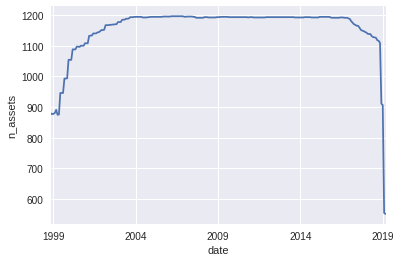

In [3]:
data.groupby('date')['stock_id'].count().plot(ylabel='n_assets');

In [4]:
features = data.columns.to_list()[2:-4]
features_short = ["Div_Yld", "Eps", "Mkt_Cap_12M_Usd", "Mom_11M_Usd", "Ocf", "Pb", "Vol1Y_Usd"]

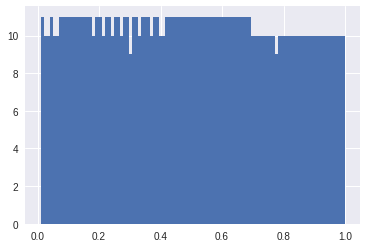

In [5]:
data.loc[(data['date']=='2000-2-29'),'Div_Yld'].hist(bins=100);

In [6]:
data['R1M_Usd_C'] = data.groupby('date')['R1M_Usd'].apply(lambda x: (x > x.median()))
data['R12M_Usd_C'] = data.groupby('date')['R12M_Usd'].apply(lambda x: (x > x.median()))

In [7]:
separation_date = '2014-1-15'
separation_mask = (data['date'] < separation_date)

training_sample = data.loc[separation_mask]
testing_sample = data.loc[~separation_mask]

In [8]:
stock_ids = data['stock_id'].unique().tolist()

max_dates = data.groupby('stock_id')['date'].count().max()
stocks_with_max_dates = data.groupby('stock_id')['date'].count() == max_dates
stock_ids_short = stocks_with_max_dates.where(stocks_with_max_dates).dropna().index.tolist()

returns = data[data['stock_id'].isin(stock_ids_short)][['date','stock_id','R1M_Usd']]
returns = returns.pivot(index='date',columns='stock_id');

### **Chapter 2.** Introduction

There is no code in this section :)

### **Chapter 3.** Factor investing and asset pricing


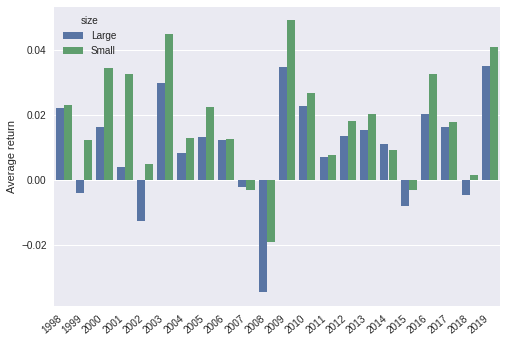

In [11]:
data['size'] = data.groupby('date')['Mkt_Cap_12M_Usd'].apply(lambda x: (x > x.median())).replace({True:'Large',False:'Small'})
data['year'] = data['date'].dt.year


return_by_size = data.groupby(['year','size'])['R1M_Usd'].mean().reset_index()

ax = sns.barplot(x='year',y='R1M_Usd',hue='size',data=return_by_size)
ax.set(xlabel = '', ylabel = 'Average return');
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right");

In [12]:
ff_url = 'http://mba.tuck.dartmouth.edu/pages/faculty/ken.french/ftp/F-F_Research_Data_5_Factors_2x3_CSV.zip'

ff_factors = pd.read_csv(ff_url, compression='zip', skiprows=3)
ff_factors.rename({'Unnamed: 0':'date','Mkt-RF':'MKT_RF'}, axis = 1, inplace=True)
ff_factors = ff_factors.loc[ff_factors['date'].str.strip(' ').str.len() == 6]

def last_day_of_month(date_value):
    return date_value.replace(day = monthrange(date_value.year, date_value.month)[1])

ff_factors['date'] = pd.to_datetime(ff_factors['date'], format = '%Y%m').apply(last_day_of_month)
ff_factors[ff_factors.columns[1:]] = ff_factors[ff_factors.columns[1:]].apply(pd.to_numeric) / 100

ff_factors.head()

,date,MKT_RF,SMB,HML,RMW,CMA,RF
0,1963-07-31,-0.0039,-0.0047,-0.0083,0.0066,-0.0115,0.0027
1,1963-08-31,0.0507,-0.0079,0.0167,0.0040,-0.0040,0.0025
2,1963-09-30,-0.0157,-0.0048,0.0018,-0.0076,0.0024,0.0027
3,1963-10-31,0.0253,-0.0129,-0.0010,0.0275,-0.0224,0.0029
4,1963-11-30,-0.0085,-0.0084,0.0171,-0.0045,0.0222,0.0027


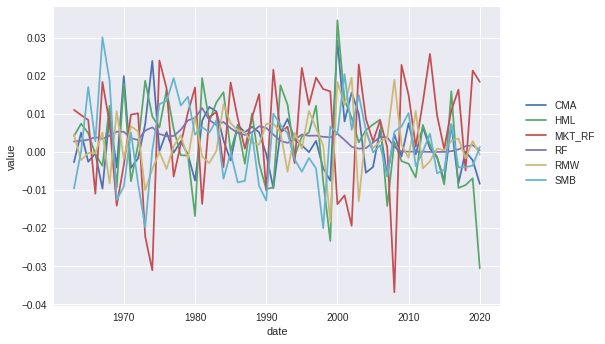

In [13]:
temp_factors = ff_factors.copy()

temp_factors['date'] = temp_factors['date'].dt.year
temp_factors = pd.melt(temp_factors, id_vars = 'date')
temp_factors = temp_factors.groupby(['date','variable']).mean().reset_index()

plt = sns.lineplot(x='date',y='value',hue='variable', data = temp_factors);
plt.legend(bbox_to_anchor=(1.05, 0.7), loc=2, borderaxespad=0.);

In [14]:
data_fm = data[['date','stock_id','R1M_Usd']][data['stock_id'].isin(stock_ids_short)]
data_fm = data_fm.merge(ff_factors, on = 'date')
data_fm['R1M_Usd'] = data_fm.groupby('stock_id')['R1M_Usd'].shift(1)
data_fm.dropna(inplace=True)

reg_output = {}

for k,g in data_fm.groupby('stock_id'):
  model = ols('R1M_Usd ~ MKT_RF + SMB + HML + RMW + CMA', data=g)
  results = model.fit()

  reg_output[k] = results.params

betas = pd.DataFrame.from_dict(reg_output).T
betas.head()

,Intercept,MKT_RF,SMB,HML,RMW,CMA
3,-0.002200,0.863631,0.854268,0.758266,0.329537,-0.311446
4,0.003501,0.287952,0.328356,-0.132163,0.633605,0.399980
7,0.006207,0.366485,0.654624,0.237586,0.254645,0.138805
9,0.003235,0.842786,0.596993,1.060169,0.105123,0.099750
16,0.000246,1.196181,-0.146711,1.368827,0.117392,-0.356427


In [15]:
loadings = betas.drop('Intercept', axis = 1).reset_index(drop=True)
ret = returns.T.reset_index(drop=True)
fm_data = pd.concat([loadings,ret], axis=1)
fm_data = pd.melt(fm_data,id_vars=['MKT_RF','SMB','HML','RMW','CMA'])

reg_output_2 = {}

for k,g in fm_data.groupby('variable'):
  model = ols('value ~ MKT_RF + SMB + HML + RMW + CMA', data=g)
  results = model.fit()

  reg_output_2[k] = results.params

gammas = pd.DataFrame.from_dict(reg_output_2).T.reset_index().rename({'index':'date'}, axis = 1)
gammas.head()

,date,Intercept,MKT_RF,SMB,HML,RMW,CMA
0,1998-11-30,0.021838,0.080532,-0.033730,-4.953960e-02,-0.022060,-0.040930
1,1998-12-31,0.012287,0.021510,0.001914,-4.496566e-02,-0.055657,-0.058210
2,1999-01-31,-0.026742,-0.043605,-0.014534,3.571688e-02,0.009899,0.034607
3,1999-02-28,-0.035103,0.046858,-0.020897,6.446910e-04,-0.019046,-0.014043
4,1999-03-31,-0.001542,0.096099,0.007436,-6.356754e-08,-0.024667,-0.018646


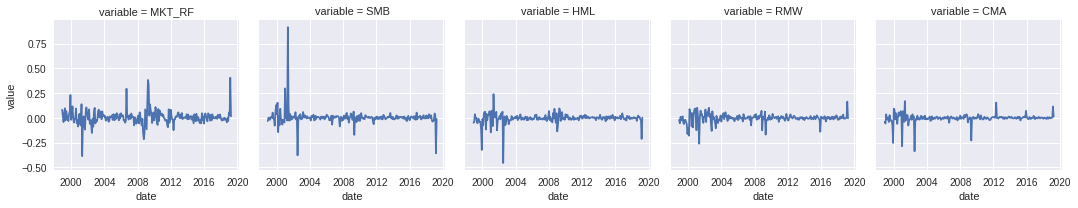

In [16]:
x = pd.melt(gammas.drop('Intercept',axis=1), id_vars='date')

g = sns.FacetGrid(x, col='variable');
g.map(sns.lineplot, 'date', 'value');

In [17]:
factor_comp = pd.melt(ff_factors.drop('RF',axis=1),id_vars='date')

factor_comp = factor_comp.merge(ff_factors.drop('RF',axis=1), on = 'date')

factor_comp_coefs = {}
factor_comp_tstats = {}

for k,g in factor_comp.groupby('variable'):

  reg_data = g.drop([k,'date','variable'],axis=1)
  formula = 'value ~ ' + ' + '.join(reg_data.columns.values[1:].tolist())
  
  model = ols(formula, data=reg_data)
  results = model.fit()

  factor_comp_coefs[k] = results.params
  factor_comp_tstats[k] = results.tvalues

alphas = pd.DataFrame.from_dict(factor_comp_coefs).T
alphas_tstats = pd.DataFrame.from_dict(factor_comp_tstats).T

alphas_tstats

,CMA,HML,Intercept,MKT_RF,RMW,SMB
CMA,NaN,23.924111,4.631638,-8.771158,-5.231794,-2.116778
HML,23.924111,NaN,-1.005809,1.686625,4.432354,2.314718
MKT_RF,-8.771158,1.686625,5.077312,NaN,-4.219644,5.455021
RMW,-5.231794,4.432354,4.880449,-4.219644,NaN,-8.523464
SMB,-2.116778,2.314718,2.408641,5.455021,-8.523464,NaN


In [18]:
alphas_table = alphas.round(3).applymap(str)

prob99 = 2.58
prob95 = 1.96

alphas_table[alphas_tstats >= prob99] = alphas_table[alphas_tstats >= prob99] + ' (**)'
alphas_table[alphas_tstats.apply(lambda x: x.between(prob95, prob99))] = alphas_table[alphas_tstats.apply(lambda x: x.between(prob95, prob99))] + ' (*)'

factors = factor_comp.columns[3:].tolist()

alphas_table = alphas_table[['Intercept'] + factors].reindex(factors)

alphas_table

,Intercept,MKT_RF,SMB,HML,RMW,CMA
MKT_RF,0.008 (**),nan,0.292 (**),0.123,-0.316,-0.925
SMB,0.003 (*),0.143 (**),nan,0.117 (*),-0.43,-0.164
HML,-0.001,0.034,0.066 (*),nan,0.174 (**),1.03 (**)
RMW,0.004 (**),-0.08,-0.223,0.161 (**),nan,-0.288
CMA,0.002 (**),-0.109,-0.04,0.442 (**),-0.134,nan


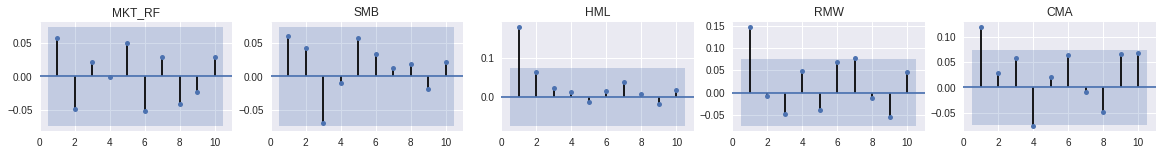

In [23]:
nfactors = len(factors)

fig, axs = plt.subplots(ncols=nfactors, figsize = (20,2))

for i, factor in enumerate(factors):
  plot_pacf(ff_factors[factor], ax = axs[i], lags = 10, zero = False, title = factor);

### **Chapter 4.** Data preprocessing

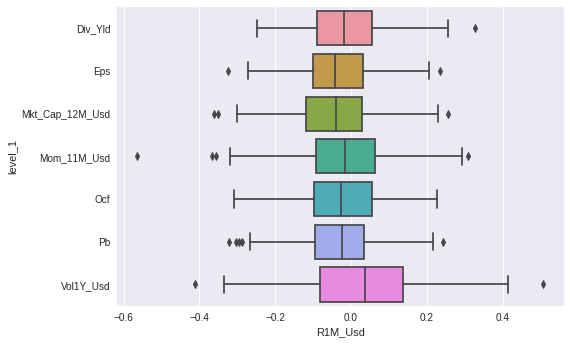

In [24]:
cols_to_keep = features_short+['R1M_Usd','date']
corr_data = data[cols_to_keep]
corr_data = corr_data.groupby('date').corr()[['R1M_Usd']].reset_index()
corr_data = corr_data.loc[corr_data['level_1']!='R1M_Usd']

sns.boxplot(x='R1M_Usd',y='level_1', data = corr_data);

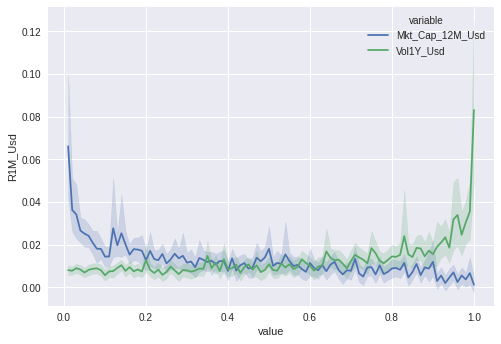

In [25]:
x = pd.melt(data[['R1M_Usd','Mkt_Cap_12M_Usd','Vol1Y_Usd']], id_vars='R1M_Usd')

sns.lineplot(data = x, y='R1M_Usd', x='value', hue='variable');

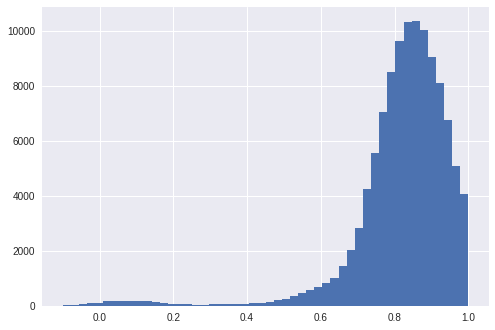

In [26]:
cols_to_keep = ['stock_id'] + features

pd.melt(data[cols_to_keep], id_vars='stock_id').groupby(['stock_id','variable']).apply(lambda x: x['value'].autocorr(lag=1)).hist(bins=50,range=[-0.1,1]);

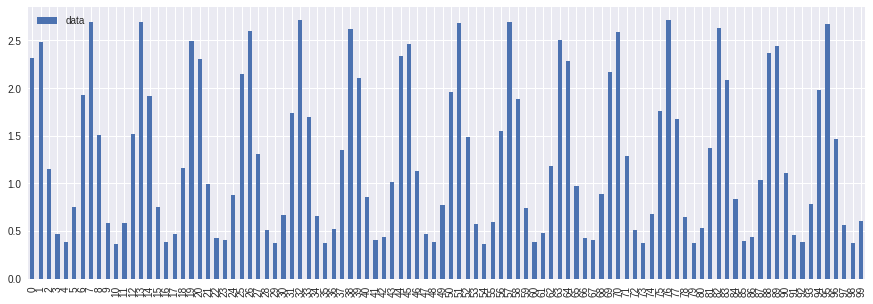

In [27]:
length = 100
x = np.exp(np.sin(np.linspace(1,length,length)))
df = pd.DataFrame(data=x,columns=['data'])

df.plot(kind='bar', figsize=(15,5));

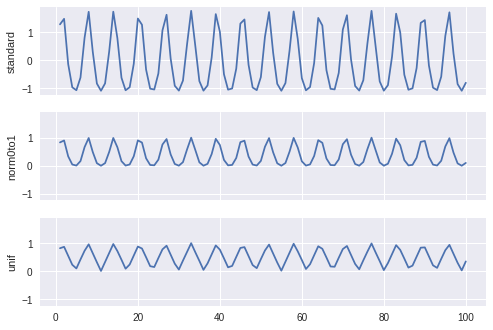

In [28]:
def norm_0to1(x):
  return ((x-np.min(x))/(np.max(x)-np.min(x)))

df = pd.DataFrame.from_dict(dict(
    index = np.linspace(1,length,length),
    standard = (x - np.mean(x))/np.std(x),
    norm0to1 = norm_0to1(x),
    unif = ECDF(x)(x)
))

fig, axs = plt.subplots(3, sharex=True, sharey=True)
for i, col in enumerate(df.columns[1:]):
  axs[i].plot(df['index'],df[col])
  axs[i].set_ylabel(col)

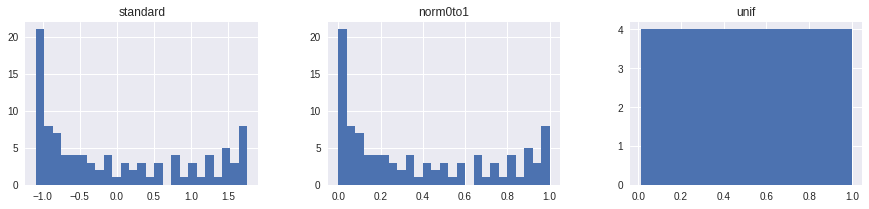

In [29]:
df.drop('index',axis=1).hist(bins=25,layout=(1,3),figsize=(15,3));

### **Chapter 5.** Penalized regressions and sparse hedging for minimum variance portfolios

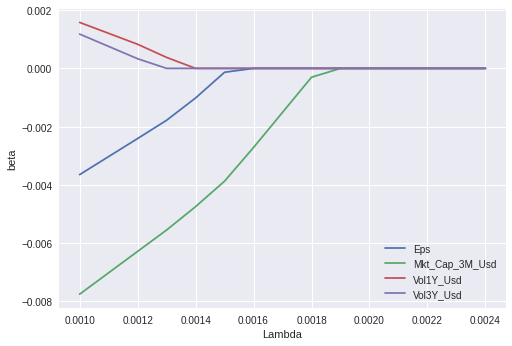

In [30]:
y_penalized = data['R1M_Usd'].values
X_penalized = data[features].values

alphas = np.arange(1e-3,2.5e-3,1e-4) # sklearn alpha = glmnet lambda

coef_path = {}

for alpha in alphas:
  lasso = Lasso(alpha=alpha)
  lasso.fit(X_penalized,y_penalized)

  coef_path[alpha] = lasso.coef_

coef_path_df = pd.DataFrame.from_dict(coef_path).T
coef_path_df.columns = features
relevant_predictors = (coef_path_df.abs().sum() != 0.0)
coef_path_df.loc[:,relevant_predictors].plot(xlabel='Lambda',ylabel='beta');

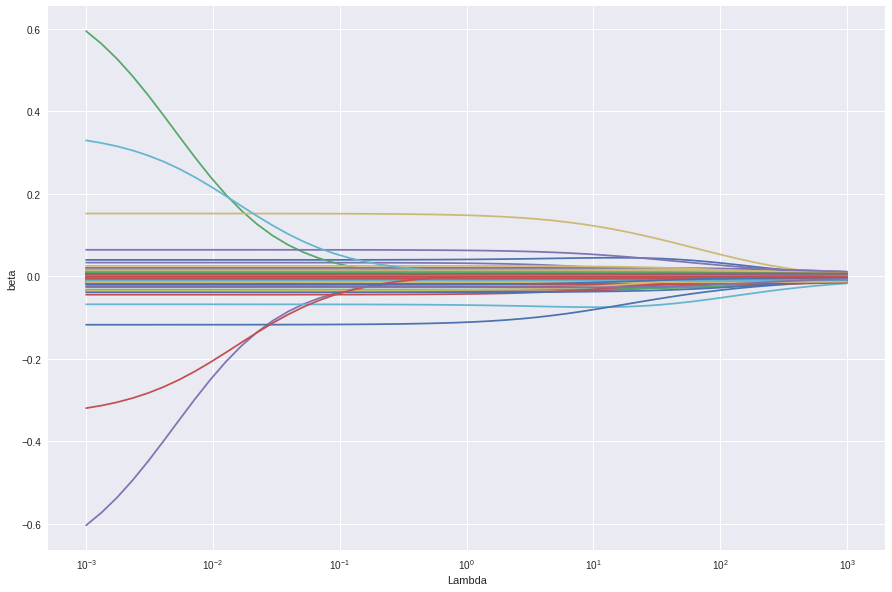

In [31]:
alphas = np.logspace(-3,3,50)

coef_path = {}

for alpha in alphas:
  ridge = Ridge(alpha=alpha)
  ridge.fit(X_penalized,y_penalized)

  coef_path[alpha] = ridge.coef_

coef_path_df = pd.DataFrame.from_dict(coef_path).T
coef_path_df.columns = features
relevant_predictors = (coef_path_df.abs().sum() != 0.0)
coef_path_df.loc[:,relevant_predictors].plot(xlabel='Lambda',ylabel='beta',figsize=(15,10),legend=False, logx=True);

In [40]:
t_oos = returns.index[returns.index > separation_date].values

Tt = len(t_oos)
nb_port = 3

def weights_sparsehedge(returns, alpha = 0.1, l1_ratio = 0.1):

  weights = []

  lr = ElasticNet(alpha=alpha,l1_ratio=l1_ratio)

  for col in returns.columns:
    y = returns[col].values
    X = returns.drop(col, axis=1).values

    lr.fit(X,y)
    err = y - lr.predict(X)
    w = (1-np.sum(lr.coef_))/np.var(err)

    weights.append(w)

  return weights / np.sum(weights)

def weights_multi(returns, j, alpha = 0.1, l1_ratio = 0.1):

  N = returns.shape[1]

  if j == 0:
    return np.repeat(1/N,N)
  elif j == 1:
    sigma = np.cov(returns.T) + 1e-2 * np.identity(N) # hardcoded penalty....
    w = np.matmul(np.linalg.inv(sigma),np.repeat(1,N))
    return w / np.sum(w)
  elif j == 2:
    return weights_sparsehedge(returns, alpha, l1_ratio)

port_weights = {}
port_returns = {}

for t, month in np.ndenumerate(t_oos):

  temp_data = returns.loc[returns.index < month]
  realised_returns = returns.loc[returns.index == month].values

  inner_dict_weights = {}
  inner_dict_returns = {}

  for j in range(nb_port):

    wgts = weights_multi(temp_data, j, 0.1, 0.1)
    rets = np.sum(wgts * realised_returns)

    inner_dict_weights[j] = wgts
    inner_dict_returns[j] = rets

  port_weights[month] = inner_dict_weights
  port_returns[month] = inner_dict_returns

In [41]:
port_returns_df = pd.concat({
        k: pd.DataFrame.from_dict(v, 'index') for k, v in port_returns.items()
    }, 
    axis=0).reset_index()

colnames = ['date','strategy','return']
port_returns_df.columns = colnames

stratmap = {0:'EW',1:'MV',2:'Sparse'}
port_returns_df['strategy'] = port_returns_df['strategy'].replace(stratmap)
port_returns_df.groupby('strategy')['return'].std()

strategy
EW        0.044998
MV        0.044598
Sparse    0.041618
Name: return, dtype: float64

In [39]:
y_penalized_train = training_sample['R1M_Usd'].values
X_penalized_train = training_sample[features].values

model = ElasticNet(alpha=0.1, l1_ratio=0.1)
model.fit(X_penalized_train,y_penalized_train)

y_penalized_test = testing_sample['R1M_Usd'].values
X_penalized_test = testing_sample[features].values

mse = np.mean((model.predict(X_penalized_test) - y_penalized_test)**2)
hitratio = np.mean(model.predict(X_penalized_test) * y_penalized_test > 0)
print(f'MSE: {mse} \nHit Ratio: {hitratio}')

MSE: 0.03949451472449276 
Hit Ratio: 0.5494447675223616


### **Chapter 6.** Tree-based methods

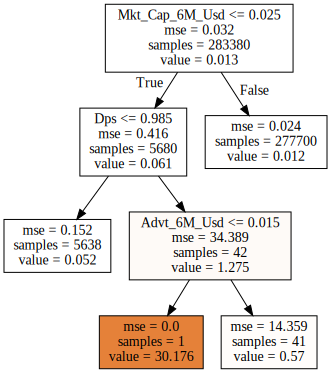

In [42]:
y = data['R1M_Usd'].values
X = data[features].values

clf = tree.DecisionTreeRegressor(max_depth=3, ccp_alpha=1e-4)
clf = clf.fit(X,y)

dot_data = tree.export_graphviz(clf,out_file=None,
                                feature_names=features,
                                filled = True)

graph = graphviz.Source(dot_data)
graph

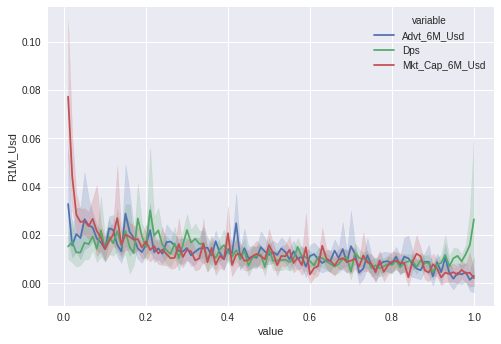

In [43]:
cols_that_matter = []

for val in np.where(clf.feature_importances_ > 0)[0]:
  cols_that_matter.append(features[val])

cols_that_matter

temp = pd.melt(data[['R1M_Usd']+cols_that_matter], id_vars='R1M_Usd')

sns.lineplot(data = temp, y='R1M_Usd', x='value', hue='variable');

In [44]:
y_train = training_sample['R1M_Usd'].values
X_train = training_sample[features].values

dt = tree.DecisionTreeRegressor(max_depth=3, ccp_alpha=1e-4)
dt.fit(X_train,y_train)

y_test = testing_sample['R1M_Usd'].values
X_test = testing_sample[features].values

mse = np.mean((dt.predict(X_test) - y_test)**2)
hitratio = np.mean(dt.predict(X_test) * y_test > 0)
print(f'MSE: {mse} \nHit Ratio: {hitratio}')

MSE: 0.03949451472449276 
Hit Ratio: 0.5494447675223616


In [45]:
rf = RandomForestRegressor(n_estimators=40,
                           max_features = 30,
                           min_samples_split=10000,
                           bootstrap=False)
rf.fit(X_train,y_train)

mse = np.mean((rf.predict(X_test) - y_test)**2)
hitratio = np.mean(rf.predict(X_test) * y_test > 0)
print(f'MSE: {mse} \nHit Ratio: {hitratio}')

MSE: 0.039443868412626454 
Hit Ratio: 0.5462047575531002


In [46]:
y_train_clf = training_sample['R1M_Usd_C']

clf = RandomForestClassifier(n_estimators=40,
                              max_features = 30,
                              min_samples_split=10000,
                              bootstrap=False)
clf.fit(X_train,y_train_clf)

y_test_clf = testing_sample['R1M_Usd_C']

hitratio = np.mean(clf.predict(X_test) == y_test_clf)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.4978815319431752


In [47]:
ada = AdaBoostClassifier()

ada.fit(X_train, y_train_clf)

hitratio = np.mean(ada.predict(X_test) == y_test_clf)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.5003323087147961


In [48]:
xgb = XGBClassifier()

xgb.fit(X_train, y_train_clf)

hitratio = np.mean(xgb.predict(X_test) == y_test_clf)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.49918307440945975


### **Chapter 7.** Neural networks

In [10]:
NN_train_features = training_sample[features].values
NN_train_labels = training_sample['R1M_Usd'].values

NN_test_features = testing_sample[features].values
NN_test_labels = testing_sample['R1M_Usd'].values

In [11]:
model = keras.Sequential(
    [
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(8, activation="tanh"),
        keras.layers.Dense(1)
    ]
)

loss_fn = keras.losses.MeanSquaredError() #regression yay
optimizer = keras.optimizers.RMSprop()

model.compile(optimizer,loss=loss_fn,metrics=['MeanAbsoluteError'])

fitted_model = model.fit(
            NN_train_features,
            NN_train_labels,
            batch_size=512,
            epochs = 10,
            validation_data=(NN_test_features,NN_test_labels),
            verbose = True
)

Epoch 1/10
413/413 [==============================] - 2s 3ms/step - loss: 0.0388 - mean_absolute_error: 0.1026 - val_loss: 0.0395 - val_mean_absolute_error: 0.0679
Epoch 2/10
413/413 [==============================] - 1s 2ms/step - loss: 0.0365 - mean_absolute_error: 0.0856 - val_loss: 0.0396 - val_mean_absolute_error: 0.0681
Epoch 3/10
413/413 [==============================] - 1s 2ms/step - loss: 0.0291 - mean_absolute_error: 0.0852 - val_loss: 0.0395 - val_mean_absolute_error: 0.0674
Epoch 4/10
413/413 [==============================] - 1s 2ms/step - loss: 0.0285 - mean_absolute_error: 0.0852 - val_loss: 0.0398 - val_mean_absolute_error: 0.0691
Epoch 5/10
413/413 [==============================] - 1s 2ms/step - loss: 0.0270 - mean_absolute_error: 0.0851 - val_loss: 0.0396 - val_mean_absolute_error: 0.0683
Epoch 6/10
413/413 [==============================] - 1s 2ms/step - loss: 0.0266 - mean_absolute_error: 0.0850 - val_loss: 0.0394 - val_mean_absolute_error: 0.0672
Epoch 7/10
413/4

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                1504      
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 1,649
Trainable params: 1,649
Non-trainable params: 0
_________________________________________________________________


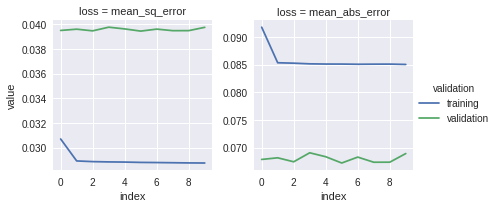

In [43]:
def plot_model_performance(mdl, loss, metric):
  x = pd.DataFrame(mdl.history).reset_index()
  x = pd.melt(x, id_vars='index')

  x['validation'] = (x['variable'].str[:4] == 'val_').replace({True:'validation',False:'training'})
  x['loss'] = (x['variable'].str[-4:] == 'loss').replace({True:loss,False:metric})

  g = sns.FacetGrid(x, col='loss', hue='validation',sharey=False)
  g.map(sns.lineplot, 'index','value')
  g.add_legend()

  return g

plot_model_performance(fitted_model,'mean_sq_error','mean_abs_error');

In [25]:
NN_preds = model.predict(NN_test_features, use_multiprocessing=True)
NN_preds = NN_preds.reshape(NN_preds.shape[0])

hitratio = np.mean(np.multiply(NN_preds,NN_test_labels) > 0)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.5492924593614135


In [32]:
NN_train_labels_C = training_sample['R1M_Usd_C'].values
NN_train_labels_C = keras.utils.to_categorical(NN_train_labels_C)

NN_test_labels_C = testing_sample['R1M_Usd_C'].values
NN_test_labels_C = keras.utils.to_categorical(NN_test_labels_C)

In [33]:
model_C = keras.Sequential(
    [
        keras.layers.Dense(16, 
                           activation="tanh",
                           kernel_initializer = 'random_normal',
                           kernel_constraint = keras.constraints.NonNeg()
                          ),
        keras.layers.Dropout(0.25),
        keras.layers.Dense(8,
                           activation="elu",
                           bias_initializer = keras.initializers.Constant(value=0.2),
                           kernel_regularizer = keras.regularizers.l2(l2=0.01)
                           ),
        keras.layers.Dense(2,
                           activation = 'softmax'
                           )
    ]
)

In [64]:
loss_fn = keras.losses.BinaryCrossentropy()
optimizer = keras.optimizers.Adam(
    learning_rate=0.005,
    beta_1=0.9,
    beta_2=0.95
)

model_C.compile(optimizer=optimizer,
                loss=loss_fn,
                metrics=['categorical_accuracy']
)

fitted_model_C = model_C.fit(
            NN_train_features,
            NN_train_labels_C,
            batch_size=512,
            epochs = 20,
            validation_data=(NN_test_features,NN_test_labels_C),
            verbose = True,
            callbacks = [keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            min_delta=0.001,
                            patience=3,
                            verbose=False
            )]
)

Epoch 1/20
413/413 [==============================] - 2s 3ms/step - loss: 0.7319 - categorical_accuracy: 0.5022 - val_loss: 0.6934 - val_categorical_accuracy: 0.4951
Epoch 2/20
413/413 [==============================] - 1s 3ms/step - loss: 0.6933 - categorical_accuracy: 0.5035 - val_loss: 0.6934 - val_categorical_accuracy: 0.4971
Epoch 3/20
413/413 [==============================] - 1s 3ms/step - loss: 0.6933 - categorical_accuracy: 0.5017 - val_loss: 0.6935 - val_categorical_accuracy: 0.4963
Epoch 4/20
413/413 [==============================] - 1s 3ms/step - loss: 0.6933 - categorical_accuracy: 0.5022 - val_loss: 0.6932 - val_categorical_accuracy: 0.4926


In [ ]:
model_C.summary()

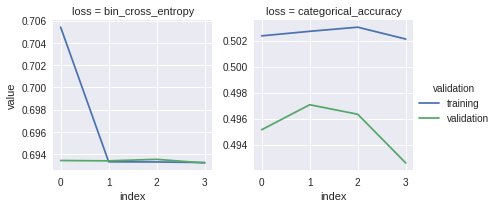

In [65]:
plot_model_performance(fitted_model_C,'bin_cross_entropy','categorical_accuracy');

In [110]:
model_custom = keras.Sequential(
    [
        keras.layers.Dense(16, activation="relu"),
        keras.layers.Dense(8, activation="sigmoid"),
        keras.layers.Dense(1)
    ]
)


def custom_loss(y_true, y_pred):
  gamma = 5

  term1 = tf.square(y_pred - tf.reduce_mean(y_pred))
  term2 = (y_true - tf.reduce_mean(y_true))*(y_pred - tf.reduce_mean(y_pred))
  
  return tf.reduce_mean(term1) - gamma * tf.reduce_mean(term2)

optimizer = keras.optimizers.RMSprop()

model_custom.compile(optimizer,loss=custom_loss,metrics=['MeanAbsoluteError'])

fitted_model_custom = model_custom.fit(
            NN_train_features,
            NN_train_labels,
            batch_size=512,
            epochs = 10,
            validation_data=(NN_test_features,NN_test_labels),
            verbose = True
)

Epoch 1/10
413/413 [==============================] - 2s 3ms/step - loss: 8.4461e-05 - mean_absolute_error: 0.3941 - val_loss: 1.5944e-04 - val_mean_absolute_error: 0.3962
Epoch 2/10
413/413 [==============================] - 1s 2ms/step - loss: -7.5746e-04 - mean_absolute_error: 0.4116 - val_loss: 1.9209e-04 - val_mean_absolute_error: 0.4307
Epoch 3/10
413/413 [==============================] - 1s 2ms/step - loss: -0.0012 - mean_absolute_error: 0.4492 - val_loss: 2.6640e-04 - val_mean_absolute_error: 0.4315
Epoch 4/10
413/413 [==============================] - 1s 2ms/step - loss: -0.0010 - mean_absolute_error: 0.4379 - val_loss: 1.4040e-04 - val_mean_absolute_error: 0.4447
Epoch 5/10
413/413 [==============================] - 1s 2ms/step - loss: -0.0013 - mean_absolute_error: 0.4468 - val_loss: 9.8087e-05 - val_mean_absolute_error: 0.4656
Epoch 6/10
413/413 [==============================] - 1s 2ms/step - loss: -0.0013 - mean_absolute_error: 0.4658 - val_loss: 3.1756e-04 - val_mean_ab

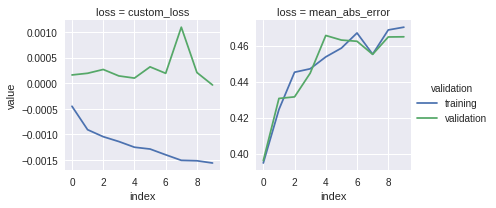

In [111]:
plot_model_performance(fitted_model_custom, 'custom_loss', 'mean_abs_error');

In [112]:
NN_preds = model_custom.predict(NN_test_features, use_multiprocessing=True)
NN_preds = NN_preds.reshape(NN_preds.shape[0])

hitratio = np.mean(np.multiply(NN_preds,NN_test_labels) > 0)
print(f'Hit Ratio: {hitratio}')

Hit Ratio: 0.4435629032704716
